In [28]:
import json
import requests

# 🔧 Change this to test different top_k values dynamically
TOP_K = 10

ORIGINAL_API = "http://localhost:8000/check-plagiarism"
THRESHOLD_API = "http://localhost:8001/check-plagiarism"

ORIGINAL_FILE = "test_cases.jsonl"
THRESHOLD_FILE = "test_cases_threshold.jsonl"

def evaluate(api_url, test_file, label, top_k):
    correct = 0
    total = 0
    misclassified = []

    print(f"\n🔍 Evaluating {label} API ({api_url})")

    with open(test_file, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f, 1):
            line = line.lstrip("\ufeff").strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"❌ Line {idx} JSONDecodeError: {e}")
                print(f"   Skipping line: {repr(line)}")
                continue

            payload = {
                "code": entry["code"],
                "top_k": top_k
            }

            # Optional field handling
            if "analyze_plagiarism" in entry:
                payload["analyze_plagiarism"] = entry["analyze_plagiarism"]

            try:
                response = requests.post(api_url, json=payload)
                response.raise_for_status()
                data = response.json()
                prediction = data.get("plagiarized") if "plagiarized" in data else data.get("plagiarism_detected", False)
            except Exception as e:
                print(f"❌ Line {idx} request failed: {e}")
                continue

            expected = entry["expected"]
            total += 1
            if prediction == expected:
                correct += 1
            else:
                misclassified.append((idx, expected, prediction, entry["code"][:300], data))

    accuracy = correct / total if total else 0
    print(f"\n📊 {label} Accuracy (top_k={top_k}): {correct}/{total} = {accuracy*100:.2f}%")
    if misclassified:
        print("❌ Misclassifications:")
        for idx, expected, predicted, snippet, full_response in misclassified:
            print(f"  Line {idx}: Expected {expected}, Got {predicted}")
            print(f"    Snippet: {snippet}...")
            print(f"    Full API response: {json.dumps(full_response, indent=2)}\n")


# 🔍 Evaluate both APIs with the same top_k
print("🔍 Evaluating Original API (localhost:8000)")
evaluate(ORIGINAL_API, ORIGINAL_FILE, "Original", TOP_K)

print("🔍 Evaluating Threshold API (localhost:8001)")
evaluate(THRESHOLD_API, THRESHOLD_FILE, "Threshold", TOP_K)


🔍 Evaluating Original API (localhost:8000)

🔍 Evaluating Original API (http://localhost:8000/check-plagiarism)

📊 Original Accuracy (top_k=10): 19/35 = 54.29%
❌ Misclassifications:
  Line 2: Expected True, Got False
    Snippet: public class T01 {
    public static void main(String[] args) {
        for(int i = 0; i < 5; i++) {
            System.out.println("Welcome To Java");
        }
    }
}...
    Full API response: {
  "plagiarism_detected": false,
  "analysis": "The query code provided does not show significant similarity to any of the similar code chunks provided. While there are some common elements like using loops and printing messages, the overall structure and purpose of the code are different. Therefore, plagiarism is not detected.",
  "confidence": 0.9,
  "model_used": "gpt-3.5-turbo",
  "similar_chunks_count": 10
}

  Line 8: Expected False, Got True
    Snippet: public class Nomor1_2451041557A22145B3701B0184109CAB013 {
    public static void main(String[] args) {
     


🔍 Evaluating Original API (http://localhost:8000/check-plagiarism)

📊 Original Accuracy (top_k=10): 33/35 = 94.29%
❌ Misclassifications:
  Line 3: Expected False, Got True
    Snippet: public class T01
{
   public static void main(String[] args)
   {
      for(int i=0;i < 5;i++)
      {
         System.out.println("Welcome To Java");
      }
      
   }
}...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided is highly similar to the code chunks [1], [2], and [5]. Although the exact content is not copied, the structure and logic are very similar. The query code iterates a specific number of times and prints a message, which is similar to the behavior in chunks [1] and [2]. Additionally, the query code involves user input and mathematical calculations, resembling the functionality in chunk [5]. The slight modifications in variable names and messages do not change the core logic of the code. Therefore, based on the high similarity in structure 

/var/folders/sm/rhn9h9_54tl6m48b_tsb7r1r0000gn/T/ipykernel_46015/1917394120.py:72: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aleksandrechikhladze/Documents/Development/Projects/Plagiarism-detector/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


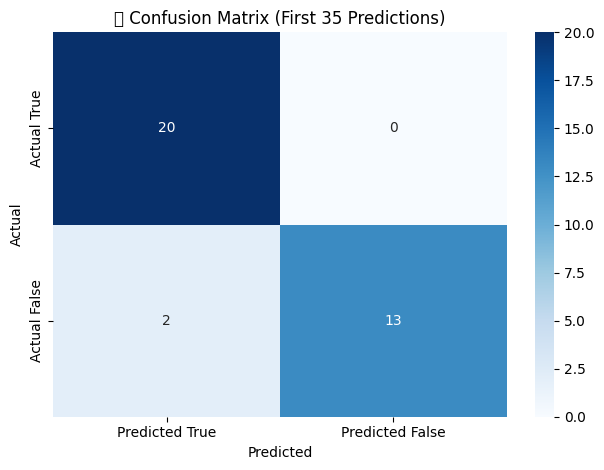


🧾 Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.87      0.93        15
        True       0.91      1.00      0.95        20

    accuracy                           0.94        35
   macro avg       0.95      0.93      0.94        35
weighted avg       0.95      0.94      0.94        35



In [64]:
import json
import requests
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

TOP_K = 10
API_URL = "http://localhost:8000/check-plagiarism"
TEST_FILE = "test_cases_1.jsonl"

def evaluate_and_visualize(api_url, test_file, top_k):
    y_true, y_pred = [], []
    misclassified = []

    print(f"\n🔍 Evaluating Original API ({api_url})")

    with open(test_file, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f, 1):
            line = line.lstrip("\ufeff").strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                expected = entry["expected"]
            except Exception as e:
                print(f"⚠️ Skipping line {idx} due to error: {e}")
                continue

            payload = {
                "code": entry["code"],
                "top_k": top_k
            }

            try:
                res = requests.post(api_url, json=payload)
                res.raise_for_status()
                result = res.json()
                predicted = result.get("plagiarism_detected", False)
            except Exception as e:
                print(f"❌ Line {idx} request failed: {e}")
                continue

            y_true.append(expected)
            y_pred.append(predicted)

            if predicted != expected:
                misclassified.append((idx, expected, predicted, entry["code"][:300], result))

    # Accuracy
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    total = len(y_true)
    accuracy = correct / total if total else 0
    print(f"\n📊 Original Accuracy (top_k={top_k}): {correct}/{total} = {accuracy*100:.2f}%")

    if misclassified:
        print("❌ Misclassifications:")
        for line_num, expected, predicted, snippet, full_response in misclassified:
            print(f"  Line {line_num}: Expected {expected}, Got {predicted}")
            print(f"    Snippet: {snippet}...")
            print(f"    Full API response: {json.dumps(full_response, indent=2)}\n")

    # Confusion Matrix for first 35
    cm = confusion_matrix(y_true[:35], y_pred[:35], labels=[True, False])
    labels = ["Actual True", "Actual False"]
    cm_df = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Predicted True", "Predicted False"],
                        yticklabels=labels)

    plt.title("🔬 Confusion Matrix (First 35 Predictions)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n🧾 Classification Report:")
    print(classification_report(y_true[:35], y_pred[:35], zero_division=0))

# Run it
evaluate_and_visualize(API_URL, TEST_FILE, TOP_K)



🔍 Evaluating Original API (http://localhost:8000/check-plagiarism)

📊 Original Accuracy (top_k=10): 17/33 = 51.52%
❌ Misclassifications:
  Line 1: Expected False, Got True
    Snippet: 
import java.util.Scanner;
/**
 *
 * @author CB6AB3315634A1E4D11B091BA48B60BA
 */
public class Nomor2_2451041557A22145B3701B0184109CAB013 {

    /**
     * @param args the command line arguments
     */
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
       ...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided is highly similar to the code chunk [1] with a similarity score of 0.99. The structure, variable names, and logic are almost identical between the query code and chunk [1]. The only differences are minor formatting changes and the author's name. Based on this high similarity score and the nature of the code overlap, it is highly likely that the query code is plagiarized from chunk [1].",
  "confidence": 0.99,
  

/var/folders/sm/rhn9h9_54tl6m48b_tsb7r1r0000gn/T/ipykernel_46015/4183324570.py:72: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aleksandrechikhladze/Documents/Development/Projects/Plagiarism-detector/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


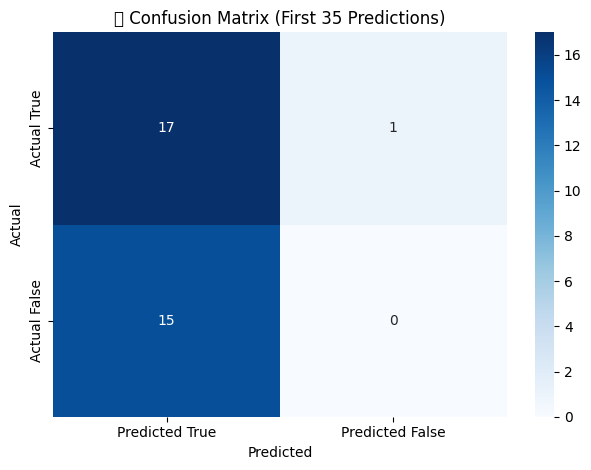


🧾 Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        15
        True       0.53      0.94      0.68        18

    accuracy                           0.52        33
   macro avg       0.27      0.47      0.34        33
weighted avg       0.29      0.52      0.37        33



In [65]:
import json
import requests
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

TOP_K = 10
API_URL = "http://localhost:8000/check-plagiarism"
TEST_FILE = "test_cases_2.jsonl"

def evaluate_and_visualize(api_url, test_file, top_k):
    y_true, y_pred = [], []
    misclassified = []

    print(f"\n🔍 Evaluating Original API ({api_url})")

    with open(test_file, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f, 1):
            line = line.lstrip("\ufeff").strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                expected = entry["expected"]
            except Exception as e:
                print(f"⚠️ Skipping line {idx} due to error: {e}")
                continue

            payload = {
                "code": entry["code"],
                "top_k": top_k
            }

            try:
                res = requests.post(api_url, json=payload)
                res.raise_for_status()
                result = res.json()
                predicted = result.get("plagiarism_detected", False)
            except Exception as e:
                print(f"❌ Line {idx} request failed: {e}")
                continue

            y_true.append(expected)
            y_pred.append(predicted)

            if predicted != expected:
                misclassified.append((idx, expected, predicted, entry["code"][:300], result))

    # Accuracy
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    total = len(y_true)
    accuracy = correct / total if total else 0
    print(f"\n📊 Original Accuracy (top_k={top_k}): {correct}/{total} = {accuracy*100:.2f}%")

    if misclassified:
        print("❌ Misclassifications:")
        for line_num, expected, predicted, snippet, full_response in misclassified:
            print(f"  Line {line_num}: Expected {expected}, Got {predicted}")
            print(f"    Snippet: {snippet}...")
            print(f"    Full API response: {json.dumps(full_response, indent=2)}\n")

    # Confusion Matrix for first 35
    cm = confusion_matrix(y_true[:35], y_pred[:35], labels=[True, False])
    labels = ["Actual True", "Actual False"]
    cm_df = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Predicted True", "Predicted False"],
                        yticklabels=labels)

    plt.title("🔬 Confusion Matrix (First 35 Predictions)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n🧾 Classification Report:")
    print(classification_report(y_true[:35], y_pred[:35], zero_division=0))

# Run it
evaluate_and_visualize(API_URL, TEST_FILE, TOP_K)



🔍 Evaluating Original API (http://localhost:8000/check-plagiarism)

📊 Original Accuracy (top_k=10): 19/32 = 59.38%
❌ Misclassifications:
  Line 1: Expected False, Got True
    Snippet: 
import java.util.Scanner;
/**
 *
 * @author CB6AB3315634A1E4D11B091BA48B60BA
 */
public class Nomor3_2451041557A22145B3701B0184109CAB013 {

    /**
     * @param args the command line arguments
     */
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
       ...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided shows a high degree of similarity with the code chunk [1]. Both codes calculate the BMI based on weight, feet, and inches input, and then classify the BMI into categories like underweight, normal, overweight, and obese. The structure, variable names, and logic are almost identical between the query code and code chunk [1]. The similarity score of 0.99 between them indicates a high likelihood of plagiarism. While

/var/folders/sm/rhn9h9_54tl6m48b_tsb7r1r0000gn/T/ipykernel_46015/1293713795.py:72: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aleksandrechikhladze/Documents/Development/Projects/Plagiarism-detector/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


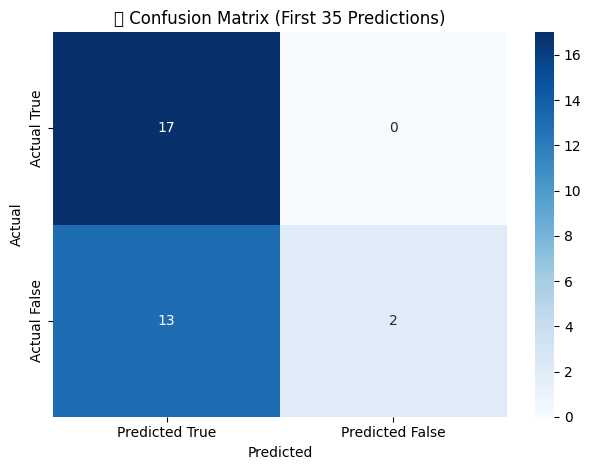


🧾 Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.13      0.24        15
        True       0.57      1.00      0.72        17

    accuracy                           0.59        32
   macro avg       0.78      0.57      0.48        32
weighted avg       0.77      0.59      0.49        32



In [66]:
import json
import requests
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

TOP_K = 10
API_URL = "http://localhost:8000/check-plagiarism"
TEST_FILE = "test_cases_3.jsonl"

def evaluate_and_visualize(api_url, test_file, top_k):
    y_true, y_pred = [], []
    misclassified = []

    print(f"\n🔍 Evaluating Original API ({api_url})")

    with open(test_file, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f, 1):
            line = line.lstrip("\ufeff").strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                expected = entry["expected"]
            except Exception as e:
                print(f"⚠️ Skipping line {idx} due to error: {e}")
                continue

            payload = {
                "code": entry["code"],
                "top_k": top_k
            }

            try:
                res = requests.post(api_url, json=payload)
                res.raise_for_status()
                result = res.json()
                predicted = result.get("plagiarism_detected", False)
            except Exception as e:
                print(f"❌ Line {idx} request failed: {e}")
                continue

            y_true.append(expected)
            y_pred.append(predicted)

            if predicted != expected:
                misclassified.append((idx, expected, predicted, entry["code"][:300], result))

    # Accuracy
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    total = len(y_true)
    accuracy = correct / total if total else 0
    print(f"\n📊 Original Accuracy (top_k={top_k}): {correct}/{total} = {accuracy*100:.2f}%")

    if misclassified:
        print("❌ Misclassifications:")
        for line_num, expected, predicted, snippet, full_response in misclassified:
            print(f"  Line {line_num}: Expected {expected}, Got {predicted}")
            print(f"    Snippet: {snippet}...")
            print(f"    Full API response: {json.dumps(full_response, indent=2)}\n")

    # Confusion Matrix for first 35
    cm = confusion_matrix(y_true[:35], y_pred[:35], labels=[True, False])
    labels = ["Actual True", "Actual False"]
    cm_df = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Predicted True", "Predicted False"],
                        yticklabels=labels)

    plt.title("🔬 Confusion Matrix (First 35 Predictions)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n🧾 Classification Report:")
    print(classification_report(y_true[:35], y_pred[:35], zero_division=0))

# Run it
evaluate_and_visualize(API_URL, TEST_FILE, TOP_K)



🔍 Evaluating Original API (http://localhost:8000/check-plagiarism)

📊 Original Accuracy (top_k=10): 22/33 = 66.67%
❌ Misclassifications:
  Line 2: Expected False, Got True
    Snippet: /*
 * To change this license header, choose License Headers in Project Properties.
 * To change this template file, choose Tools | Templates
 * and open the template in the editor.
 */

/**
 *
 * @author 685903EF83F7A7C8A165F77EED160D9E
 */
public class T04 {
    public static void main(String[] arg...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided is highly similar to the code chunk [6]. Both codes are calculating miles to kilometers conversion using a loop structure. The structure, variable names, and logic are almost identical. The only difference is the use of 'for' loop in the query code and 'while' loop in the similar code chunk. This similarity indicates a high likelihood of plagiarism.",
  "confidence": 0.98,
  "model_used": "gpt-3.5-turbo",
  "sim

/var/folders/sm/rhn9h9_54tl6m48b_tsb7r1r0000gn/T/ipykernel_46015/652700016.py:72: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aleksandrechikhladze/Documents/Development/Projects/Plagiarism-detector/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


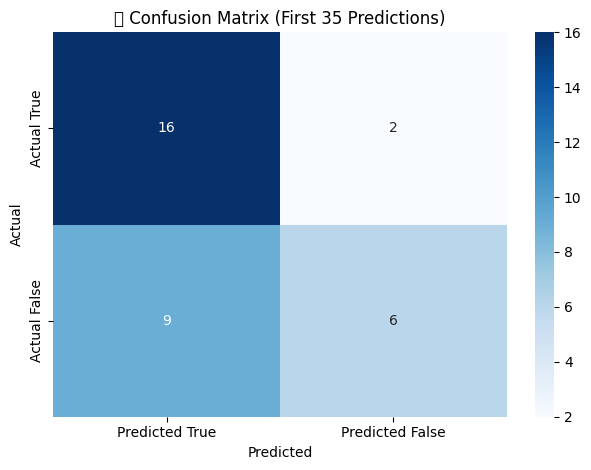


🧾 Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.40      0.52        15
        True       0.64      0.89      0.74        18

    accuracy                           0.67        33
   macro avg       0.70      0.64      0.63        33
weighted avg       0.69      0.67      0.64        33



In [49]:
import json
import requests
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

TOP_K = 10
API_URL = "http://localhost:8000/check-plagiarism"
TEST_FILE = "test_cases_4.jsonl"

def evaluate_and_visualize(api_url, test_file, top_k):
    y_true, y_pred = [], []
    misclassified = []

    print(f"\n🔍 Evaluating Original API ({api_url})")

    with open(test_file, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f, 1):
            line = line.lstrip("\ufeff").strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                expected = entry["expected"]
            except Exception as e:
                print(f"⚠️ Skipping line {idx} due to error: {e}")
                continue

            payload = {
                "code": entry["code"],
                "top_k": top_k
            }

            try:
                res = requests.post(api_url, json=payload)
                res.raise_for_status()
                result = res.json()
                predicted = result.get("plagiarism_detected", False)
            except Exception as e:
                print(f"❌ Line {idx} request failed: {e}")
                continue

            y_true.append(expected)
            y_pred.append(predicted)

            if predicted != expected:
                misclassified.append((idx, expected, predicted, entry["code"][:300], result))

    # Accuracy
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    total = len(y_true)
    accuracy = correct / total if total else 0
    print(f"\n📊 Original Accuracy (top_k={top_k}): {correct}/{total} = {accuracy*100:.2f}%")

    if misclassified:
        print("❌ Misclassifications:")
        for line_num, expected, predicted, snippet, full_response in misclassified:
            print(f"  Line {line_num}: Expected {expected}, Got {predicted}")
            print(f"    Snippet: {snippet}...")
            print(f"    Full API response: {json.dumps(full_response, indent=2)}\n")

    # Confusion Matrix for first 35
    cm = confusion_matrix(y_true[:35], y_pred[:35], labels=[True, False])
    labels = ["Actual True", "Actual False"]
    cm_df = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Predicted True", "Predicted False"],
                        yticklabels=labels)

    plt.title("🔬 Confusion Matrix (First 35 Predictions)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n🧾 Classification Report:")
    print(classification_report(y_true[:35], y_pred[:35], zero_division=0))

# Run it
evaluate_and_visualize(API_URL, TEST_FILE, TOP_K)



🔍 Evaluating Original API (http://localhost:8000/check-plagiarism)

📊 Original Accuracy (top_k=10): 23/32 = 71.88%
❌ Misclassifications:
  Line 1: Expected False, Got True
    Snippet: 
import java.util.Scanner;
/**
 *
 * @author CB6AB3315634A1E4D11B091BA48B60BA
 */
public class Nomor5_2451041557A22145B3701B0184109CAB013 {

    /**
     * @param args the command line arguments
     */
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
       ...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided shows significant similarity to the provided similar code chunks. The structure, variable names, and logic are very similar to the code chunk [5] (Similarity score: 0.99) which deals with reversing an integer. While the specific functionality is slightly different, the core logic of reversing an integer is identical. Additionally, the query code shares similarities with code chunk [1] (Similarity score: 0.99) in

/var/folders/sm/rhn9h9_54tl6m48b_tsb7r1r0000gn/T/ipykernel_46015/3001331195.py:72: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aleksandrechikhladze/Documents/Development/Projects/Plagiarism-detector/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


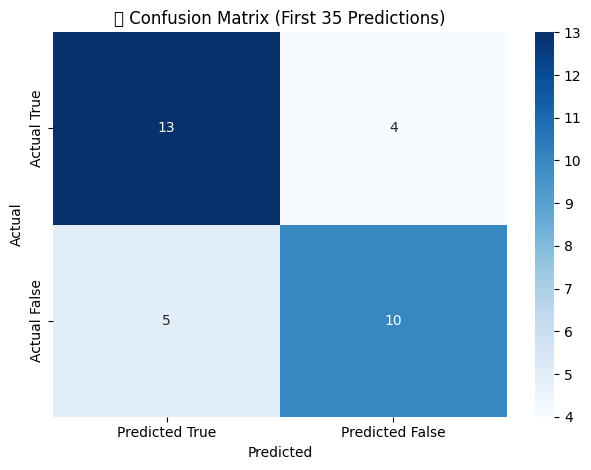


🧾 Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.67      0.69        15
        True       0.72      0.76      0.74        17

    accuracy                           0.72        32
   macro avg       0.72      0.72      0.72        32
weighted avg       0.72      0.72      0.72        32



In [51]:
import json
import requests
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

TOP_K = 10
API_URL = "http://localhost:8000/check-plagiarism"
TEST_FILE = "test_cases_5.jsonl"

def evaluate_and_visualize(api_url, test_file, top_k):
    y_true, y_pred = [], []
    misclassified = []

    print(f"\n🔍 Evaluating Original API ({api_url})")

    with open(test_file, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f, 1):
            line = line.lstrip("\ufeff").strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                expected = entry["expected"]
            except Exception as e:
                print(f"⚠️ Skipping line {idx} due to error: {e}")
                continue

            payload = {
                "code": entry["code"],
                "top_k": top_k
            }

            try:
                res = requests.post(api_url, json=payload)
                res.raise_for_status()
                result = res.json()
                predicted = result.get("plagiarism_detected", False)
            except Exception as e:
                print(f"❌ Line {idx} request failed: {e}")
                continue

            y_true.append(expected)
            y_pred.append(predicted)

            if predicted != expected:
                misclassified.append((idx, expected, predicted, entry["code"][:300], result))

    # Accuracy
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    total = len(y_true)
    accuracy = correct / total if total else 0
    print(f"\n📊 Original Accuracy (top_k={top_k}): {correct}/{total} = {accuracy*100:.2f}%")

    if misclassified:
        print("❌ Misclassifications:")
        for line_num, expected, predicted, snippet, full_response in misclassified:
            print(f"  Line {line_num}: Expected {expected}, Got {predicted}")
            print(f"    Snippet: {snippet}...")
            print(f"    Full API response: {json.dumps(full_response, indent=2)}\n")

    # Confusion Matrix for first 35
    cm = confusion_matrix(y_true[:35], y_pred[:35], labels=[True, False])
    labels = ["Actual True", "Actual False"]
    cm_df = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Predicted True", "Predicted False"],
                        yticklabels=labels)

    plt.title("🔬 Confusion Matrix (First 35 Predictions)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n🧾 Classification Report:")
    print(classification_report(y_true[:35], y_pred[:35], zero_division=0))

# Run it
evaluate_and_visualize(API_URL, TEST_FILE, TOP_K)



🔍 Evaluating Original API (http://localhost:8000/check-plagiarism)

📊 Original Accuracy (top_k=10): 19/31 = 61.29%
❌ Misclassifications:
  Line 3: Expected False, Got True
    Snippet: import java.util.Scanner;
public class T06
{
   public static void main(String[] args)
   {
      
      Scanner sc = new Scanner(System.in);
      int[] numbers = new int[10];
      for(int i=0;i < 10;i++)
      {
         System.out.print("Read a number: ");
         numbers[i]= sc.nextInt();
    ...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided shows a high degree of similarity with the provided similar code chunks. The structure, variable names, and logic are almost identical to the code in chunk [1]. While there are slight variations in variable names and comments, the core functionality remains the same. Additionally, the code in chunk [6] also shows a similar structure with a while loop for iteration. The combination of these similarities indicates

/var/folders/sm/rhn9h9_54tl6m48b_tsb7r1r0000gn/T/ipykernel_46015/3572186629.py:72: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aleksandrechikhladze/Documents/Development/Projects/Plagiarism-detector/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


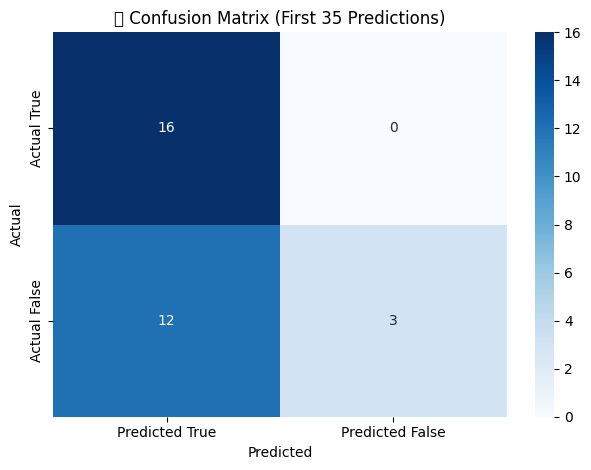


🧾 Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.20      0.33        15
        True       0.57      1.00      0.73        16

    accuracy                           0.61        31
   macro avg       0.79      0.60      0.53        31
weighted avg       0.78      0.61      0.54        31



In [50]:
import json
import requests
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

TOP_K = 10
API_URL = "http://localhost:8000/check-plagiarism"
TEST_FILE = "test_cases_6.jsonl"

def evaluate_and_visualize(api_url, test_file, top_k):
    y_true, y_pred = [], []
    misclassified = []

    print(f"\n🔍 Evaluating Original API ({api_url})")

    with open(test_file, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f, 1):
            line = line.lstrip("\ufeff").strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                expected = entry["expected"]
            except Exception as e:
                print(f"⚠️ Skipping line {idx} due to error: {e}")
                continue

            payload = {
                "code": entry["code"],
                "top_k": top_k
            }

            try:
                res = requests.post(api_url, json=payload)
                res.raise_for_status()
                result = res.json()
                predicted = result.get("plagiarism_detected", False)
            except Exception as e:
                print(f"❌ Line {idx} request failed: {e}")
                continue

            y_true.append(expected)
            y_pred.append(predicted)

            if predicted != expected:
                misclassified.append((idx, expected, predicted, entry["code"][:300], result))

    # Accuracy
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    total = len(y_true)
    accuracy = correct / total if total else 0
    print(f"\n📊 Original Accuracy (top_k={top_k}): {correct}/{total} = {accuracy*100:.2f}%")

    if misclassified:
        print("❌ Misclassifications:")
        for line_num, expected, predicted, snippet, full_response in misclassified:
            print(f"  Line {line_num}: Expected {expected}, Got {predicted}")
            print(f"    Snippet: {snippet}...")
            print(f"    Full API response: {json.dumps(full_response, indent=2)}\n")

    # Confusion Matrix for first 35
    cm = confusion_matrix(y_true[:35], y_pred[:35], labels=[True, False])
    labels = ["Actual True", "Actual False"]
    cm_df = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Predicted True", "Predicted False"],
                        yticklabels=labels)

    plt.title("🔬 Confusion Matrix (First 35 Predictions)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n🧾 Classification Report:")
    print(classification_report(y_true[:35], y_pred[:35], zero_division=0))

# Run it
evaluate_and_visualize(API_URL, TEST_FILE, TOP_K)


🔍 Evaluating test cases: ['test_cases_1.jsonl', 'test_cases_2.jsonl', 'test_cases_3.jsonl', 'test_cases_4.jsonl', 'test_cases_5.jsonl', 'test_cases_6.jsonl']

🔍 Evaluating test_cases_1.jsonl

📊 Accuracy for test_cases_1.jsonl (top_k=10): 32/35 = 91.43%
❌ Misclassifications:
  Line 3: Expected False, Got True
    Snippet: public class T01
{
   public static void main(String[] args)
   {
      for(int i=0;i < 5;i++)
      {
         System.out.println("Welcome To Java");
      }
      
   }
}...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided is highly similar to the code chunks [1], [2], and [5]. Although the exact code structure is not replicated, the core logic and functionality are very similar. The query code prints a message multiple times in a loop, which is also present in chunk [2]. Additionally, the query code involves using System.out.println and a loop, which is similar to chunk [1]. Moreover, the query code involves taking input

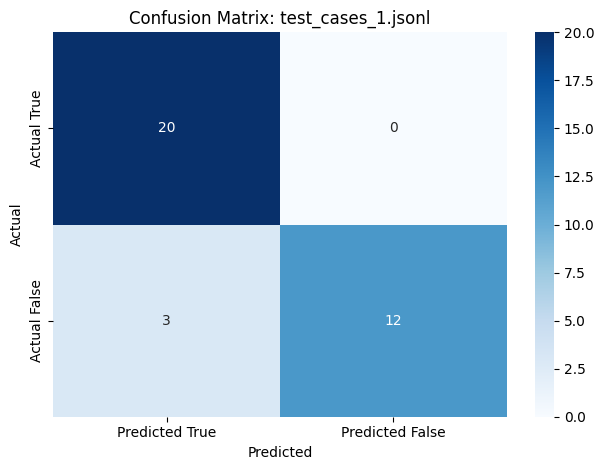


🧾 Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.80      0.89        15
        True       0.87      1.00      0.93        20

    accuracy                           0.91        35
   macro avg       0.93      0.90      0.91        35
weighted avg       0.93      0.91      0.91        35


🔍 Evaluating test_cases_2.jsonl

📊 Accuracy for test_cases_2.jsonl (top_k=10): 16/33 = 48.48%
❌ Misclassifications:
  Line 1: Expected False, Got True
    Snippet: 
import java.util.Scanner;
/**
 *
 * @author CB6AB3315634A1E4D11B091BA48B60BA
 */
public class Nomor2_2451041557A22145B3701B0184109CAB013 {

    /**
     * @param args the command line arguments
     */
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
       ...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided is highly similar to the code chunk [1] with a similarity score of 0.99. Both codes

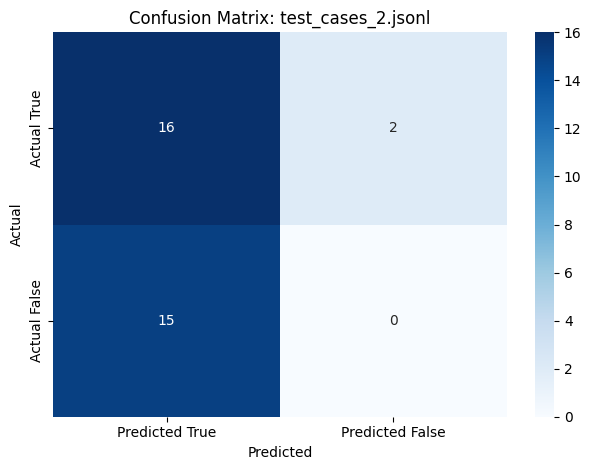


🧾 Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        15
        True       0.52      0.89      0.65        18

    accuracy                           0.48        33
   macro avg       0.26      0.44      0.33        33
weighted avg       0.28      0.48      0.36        33


🔍 Evaluating test_cases_3.jsonl

📊 Accuracy for test_cases_3.jsonl (top_k=10): 19/32 = 59.38%
❌ Misclassifications:
  Line 1: Expected False, Got True
    Snippet: 
import java.util.Scanner;
/**
 *
 * @author CB6AB3315634A1E4D11B091BA48B60BA
 */
public class Nomor3_2451041557A22145B3701B0184109CAB013 {

    /**
     * @param args the command line arguments
     */
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
       ...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided shows a high degree of similarity with the code chunk [1]. Both codes calculate the

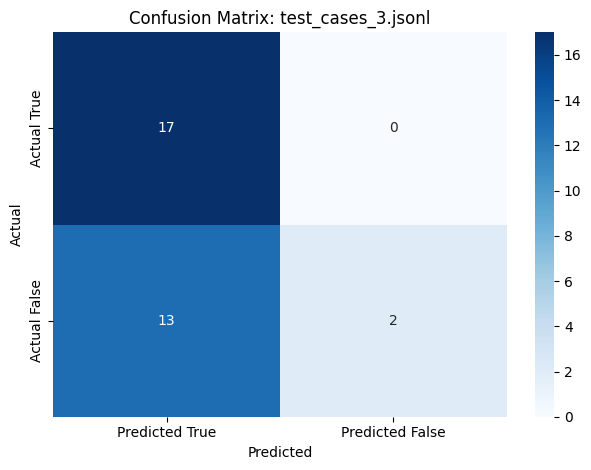


🧾 Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.13      0.24        15
        True       0.57      1.00      0.72        17

    accuracy                           0.59        32
   macro avg       0.78      0.57      0.48        32
weighted avg       0.77      0.59      0.49        32


🔍 Evaluating test_cases_4.jsonl

📊 Accuracy for test_cases_4.jsonl (top_k=10): 20/33 = 60.61%
❌ Misclassifications:
  Line 1: Expected False, Got True
    Snippet: 
/**
 *
 * @author CB6AB3315634A1E4D11B091BA48B60BA
 */
public class Nomor4_2451041557A22145B3701B0184109CAB013 {

    /**
     * @param args the command line arguments
     */
    public static void main(String[] args) {
        System.out.println("Miles \t Kilometers");
        for(int i = 1 ; i<=...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided is highly similar to the code chunk [1] with a similarity score of 0.99. Both codes

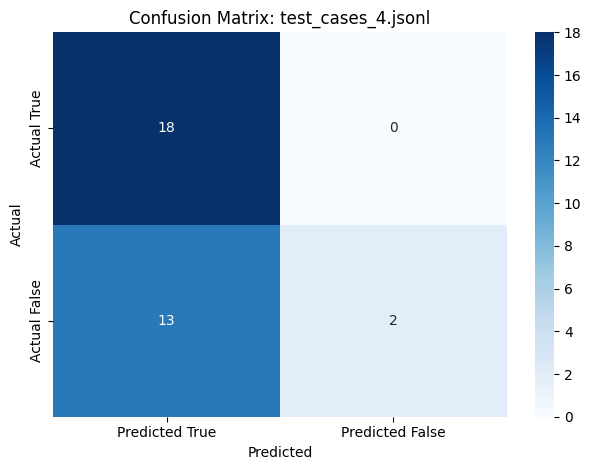


🧾 Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.13      0.24        15
        True       0.58      1.00      0.73        18

    accuracy                           0.61        33
   macro avg       0.79      0.57      0.48        33
weighted avg       0.77      0.61      0.51        33


🔍 Evaluating test_cases_5.jsonl

📊 Accuracy for test_cases_5.jsonl (top_k=10): 25/32 = 78.12%
❌ Misclassifications:
  Line 1: Expected False, Got True
    Snippet: 
import java.util.Scanner;
/**
 *
 * @author CB6AB3315634A1E4D11B091BA48B60BA
 */
public class Nomor5_2451041557A22145B3701B0184109CAB013 {

    /**
     * @param args the command line arguments
     */
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
       ...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided shows significant similarities with the provided similar code chunks. The structure

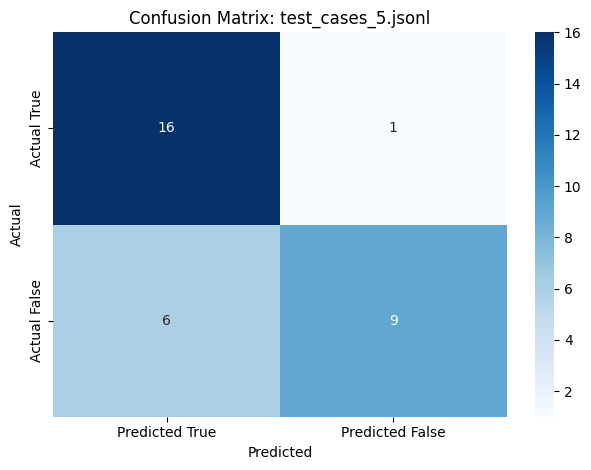


🧾 Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.60      0.72        15
        True       0.73      0.94      0.82        17

    accuracy                           0.78        32
   macro avg       0.81      0.77      0.77        32
weighted avg       0.81      0.78      0.77        32


🔍 Evaluating test_cases_6.jsonl

📊 Accuracy for test_cases_6.jsonl (top_k=10): 17/31 = 54.84%
❌ Misclassifications:
  Line 1: Expected False, Got True
    Snippet: 
import java.util.Scanner;
/**
 *
 * @author CB6AB3315634A1E4D11B091BA48B60BA
 */
public class Nomor6_2451041557A22145B3701B0184109CAB013 {

    /**
     * @param args the command line arguments
     */
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
       ...
    Full API response: {
  "plagiarism_detected": true,
  "analysis": "The query code provided shows a high similarity score (0.99) with multiple similar code chunks provided. Th

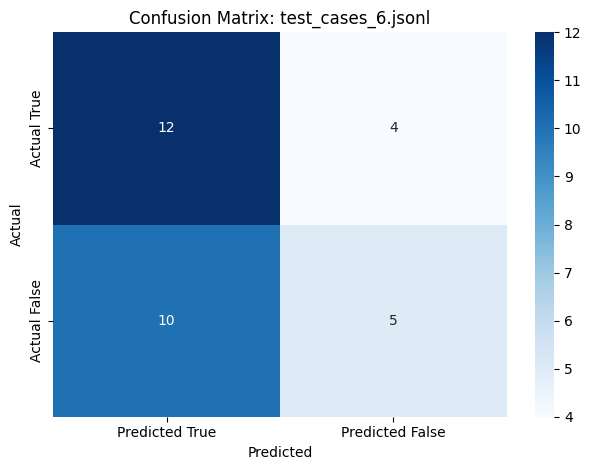


🧾 Classification Report:
              precision    recall  f1-score   support

       False       0.56      0.33      0.42        15
        True       0.55      0.75      0.63        16

    accuracy                           0.55        31
   macro avg       0.55      0.54      0.52        31
weighted avg       0.55      0.55      0.53        31



In [69]:
import json
import requests
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cases = [1,4,5]
TOP_K = 10
API_URL = "http://localhost:8000/check-plagiarism"
TEST_CASE_FILES = [f"test_cases_{i}.jsonl" for i in range(1,7)]
print(f"🔍 Evaluating test cases: {TEST_CASE_FILES}")

def evaluate_file(test_file, top_k):
    y_true, y_pred = [], []
    misclassified = []

    print(f"\n🔍 Evaluating {test_file}")

    with open(test_file, "r", encoding="utf-8") as f:
        for idx, line in enumerate(f, 1):
            line = line.lstrip("\ufeff").strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
                expected = entry["expected"]
            except Exception as e:
                print(f"⚠️ Skipping line {idx} due to error: {e}")
                continue

            payload = {
                "code": entry["code"],
                "top_k": top_k
            }

            try:
                res = requests.post(API_URL, json=payload)
                res.raise_for_status()
                result = res.json()
                predicted = result.get("plagiarism_detected", False)
            except Exception as e:
                print(f"❌ Line {idx} request failed: {e}")
                continue

            y_true.append(expected)
            y_pred.append(predicted)

            if predicted != expected:
                misclassified.append((idx, expected, predicted, entry["code"][:300], result))

    correct = sum(1 for t, p in zip(y_true, y_pred) if t == p)
    total = len(y_true)
    accuracy = correct / total if total else 0
    print(f"\n📊 Accuracy for {test_file} (top_k={top_k}): {correct}/{total} = {accuracy*100:.2f}%")

    if misclassified:
        print("❌ Misclassifications:")
        for line_num, expected, predicted, snippet, full_response in misclassified:
            print(f"  Line {line_num}: Expected {expected}, Got {predicted}")
            print(f"    Snippet: {snippet}...")
            print(f"    Full API response: {json.dumps(full_response, indent=2)}\n")

    if len(y_true) >= 2:
        cm = confusion_matrix(y_true, y_pred, labels=[True, False])
        labels = ["Actual True", "Actual False"]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Predicted True", "Predicted False"],
                    yticklabels=labels)
        plt.title(f"Confusion Matrix: {test_file}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        print("\n🧾 Classification Report:")
        print(classification_report(y_true, y_pred, zero_division=0))

def evaluate_all():
    for test_file in TEST_CASE_FILES:
        if os.path.exists(test_file):
            evaluate_file(test_file, TOP_K)
        else:
            print(f"⚠️ File {test_file} not found.")

# Run evaluation
evaluate_all()